# Notebook 3 — Cross-user verification of daily exploration patterns

### 1. More Geolife users

Notebook 3 moves from single-user analysis to a cross-user perspective on daily mobility. Building on the visit-level tables constructed in the previous notebooks, it aggregates data for a set of long-coverage Geolife users (data/visit_level_table_XXX.csv) and asks how their trip-level “going home” and exploration behaviour compares.

The workflow has three components. 

First, I define a consistent sample of users with sufficiently long observation windows and, for each of them, reconstruct home–home trips by attaching a trip identifier and within-trip stop order to every visit. 

Second, I summarise each user’s mobility with a compact set of trip-level statistics, including the number of active days, the frequency and length of home–home trips, and simple indicators of how often non-home stops correspond to first-time places (Pv) versus revisits. 

Third, I compare going-home hazards and within-trip exploration patterns across individuals by fitting user-specific discrete-time logit models in the stop order index, which yield a small number of interpretable parameters describing both the overall level and the within-trip dynamics of “going home” and “exploring” for each person.

In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="DataFrameGroupBy.apply operated on the grouping columns",
    category=FutureWarning,
)
warnings.filterwarnings(
    "ignore",
    message="Parsing dates in %d/%m/%Y format",
    category=UserWarning,
)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use("default")

DATA_DIR = "data"  # folder containing visit_level_table_XXX.csv

# Pre-selected long-coverage users (can be updated if needed)
LONG_USERS = [
    "004", "003", "017", "025", "030", "126",
    "062", "084", "039", "041", "022", "014", "000",
    "002", "092", "112", "104", "052"
]


def load_visit_table_from_csv(user_id: str,
                              data_dir: str = DATA_DIR,
                              verbose: bool = True) -> pd.DataFrame | None:
    """
    Load visit_level_table_XXX.csv for one user and parse timestamps.
    Assumes the schema from Notebook 1 / 2:
      - person
      - date, first_time, last_time
      - is_home, next_step, dist_home_m
      - visit_order_in_day, is_pv, is_pn
    """
    fname = f"visit_level_table_{user_id}.csv"
    path = os.path.join(data_dir, fname)

    if not os.path.exists(path):
        if verbose:
            print(f"[skip] {fname} not found at {path}")
        return None

    vt = pd.read_csv(path)
    if vt.empty:
        if verbose:
            print(f"[skip] {fname} is empty")
        return None

    vt["date"] = pd.to_datetime(vt["date"]).dt.date
    vt["first_dt"] = pd.to_datetime(vt["date"].astype(str) + " " + vt["first_time"])
    vt["last_dt"] = pd.to_datetime(vt["date"].astype(str) + " " + vt["last_time"])

    vt = (
        vt.sort_values(["person", "date", "first_dt"])
          .reset_index(drop=True)
    )
    return vt


def add_trip_cols_one_day(df_day: pd.DataFrame) -> pd.DataFrame:
    """
    For a single (person, date), label home–home trip episodes.

    trip_id:
      0 if no trip yet; 1,2,... for successive trips in that day
    action_order_in_trip:
      0 for HOME visits; 1,2,... for non-home stops within a trip
    """
    df_day = df_day.sort_values("first_dt").copy()

    trip_id = 0
    action_order = 0
    out = False  # currently away from HOME?

    trip_ids = []
    action_orders = []

    for _, row in df_day.iterrows():
        if row["is_home"] == 1:
            out = False
            action_order = 0
            trip_ids.append(trip_id)
            action_orders.append(0)
        else:
            if not out:
                trip_id += 1
                action_order = 1
                out = True
            else:
                action_order += 1

            trip_ids.append(trip_id)
            action_orders.append(action_order)

    df_day["trip_id"] = trip_ids
    df_day["action_order_in_trip"] = action_orders
    return df_day


def attach_trip_structure(vt: pd.DataFrame) -> pd.DataFrame:
    """Apply add_trip_cols_one_day to each (person, date)."""
    vt_trips = (
        vt.groupby(["person", "date"], group_keys=False)
          .apply(add_trip_cols_one_day)
          .reset_index(drop=True)
    )
    return vt_trips


### 2. Per-user trip-level summary

In this step I construct a compact trip-level “fingerprint” for each long-coverage user. Starting from the visit-level tables, I first re-attach home–home trip structure and then summarise overall trip patterns: the number of days with data, the number of days with at least one non-home stop, the total number of trips, and the distribution of non-home stops per trip (mean, median, maximum). On top of this, I estimate a discrete-time going-home model for each user, collapsing the full hazard curve into three parameters: the empirical probability of going home after the first stop, a pooled hazard for stops two and above, and a logit slope describing how the going-home probability changes with stop order. Finally, I fit a within-trip exploration model that records the overall share of first-time places (Pv) among non-home stops and an odds ratio describing how the odds of visiting a new place change with each additional stop in the trip. The resulting `summary_df` has one row per user and collects these trip, hazard, and exploration statistics for subsequent cross-user comparison.


In [2]:
def summarise_trip_structure(vt_trips: pd.DataFrame) -> dict:
    """
    Basic trip-level stats:
      - n_days_total: days with any record
      - n_days_nonhome: days with at least one non-home stop
      - n_trips: number of home–home trips
      - mean / median / max non-home stops per trip
    """
    nonhome = vt_trips[
        (vt_trips["trip_id"] > 0) &
        (vt_trips["is_home"] == 0) &
        (vt_trips["action_order_in_trip"] > 0)
    ].copy()

    n_days_total = vt_trips["date"].nunique()
    n_days_nonhome = nonhome["date"].nunique()

    trips = (
        nonhome[["person", "date", "trip_id", "action_order_in_trip"]]
        .groupby(["person", "date", "trip_id"], as_index=False)
        .agg(n_stops=("action_order_in_trip", "max"))
    )

    if trips.empty:
        return {
            "n_days_total": n_days_total,
            "n_days_nonhome": n_days_nonhome,
            "n_trips": 0,
            "mean_stops_per_trip": np.nan,
            "median_stops_per_trip": np.nan,
            "max_stops_per_trip": np.nan,
        }

    return {
        "n_days_total": n_days_total,
        "n_days_nonhome": n_days_nonhome,
        "n_trips": len(trips),
        "mean_stops_per_trip": trips["n_stops"].mean(),
        "median_stops_per_trip": trips["n_stops"].median(),
        "max_stops_per_trip": trips["n_stops"].max(),
    }


def fit_hazard_trip(vt_trips: pd.DataFrame,
                    maxk: int = 30,
                    night_hour: int = 23,
                    near_home_m: float = 750.0,
                    min_risk: int = 20) -> dict:
    """
    Trip-level discrete-time hazard of going home:
      - hazard_h1: empirical hazard at k=1
      - hazard_h2_const: pooled hazard over k>=2
      - hazard_beta_k: logit slope of hazard vs k for k>=2
    """
    vis = vt_trips[
        (vt_trips["is_home"] == 0) &
        (vt_trips["trip_id"] > 0) &
        (vt_trips["action_order_in_trip"] > 0)
    ].copy()
    vis = vis[vis["action_order_in_trip"] <= maxk].copy()

    if vis.empty:
        return {
            "hazard_h1": np.nan,
            "hazard_h2_const": np.nan,
            "hazard_beta_k": np.nan,
        }

    vis["outcome"] = np.where(
        vis["next_step"] == "home", "home",
        np.where(vis["next_step"].isin(["sw", "pv", "pn"]), "explore", "end")
    )

    # Last non-home stop in each trip
    last_mask = vis.groupby(
        ["person", "date", "trip_id"]
    ).cumcount(ascending=False).eq(0)

    last_time_dt = pd.to_datetime(
        vis["last_time"], format="%H:%M:%S", errors="coerce"
    )
    late = last_time_dt.dt.hour.ge(night_hour)
    near = vis["dist_home_m"].le(near_home_m)

    vis.loc[
        last_mask & (vis["outcome"] == "end") & (late | near),
        "outcome"
    ] = "home"

    pertrip_maxk = (
        vis.groupby(["person", "date", "trip_id"])["action_order_in_trip"]
           .max()
    )

    at_risk = pd.Series(
        {k: int((pertrip_maxk >= k).sum()) for k in range(1, maxk + 1)},
        name="at_risk"
    )

    home_k = (
        vis[vis["outcome"] == "home"]
        .groupby("action_order_in_trip")
        .size()
        .reindex(range(1, maxk + 1), fill_value=0)
        .rename("home_k")
    )

    hazard = (home_k / at_risk.replace(0, np.nan)).rename("hazard")
    haz_df = pd.concat([home_k, at_risk, hazard], axis=1)

    # k = 1
    hazard_h1 = haz_df.loc[1, "hazard"] if at_risk.loc[1] > 0 else np.nan

    # pooled hazard for k >= 2
    mask_ge2 = (haz_df.index >= 2) & (haz_df["at_risk"] > 0)
    if mask_ge2.any():
        H_num = haz_df.loc[mask_ge2, "home_k"].sum()
        H_den = haz_df.loc[mask_ge2, "at_risk"].sum()
        hazard_h2_const = H_num / H_den if H_den > 0 else np.nan
    else:
        hazard_h2_const = np.nan

    # logit slope for k >= 2
    haz_fit = (
        haz_df
        .loc[haz_df.index >= 2]
        .loc[lambda df: df["at_risk"] >= min_risk]
        .copy()
    )

    if haz_fit.empty:
        hazard_beta_k = np.nan
    else:
        k_fit = haz_fit.index.values.astype(float)
        X = sm.add_constant(k_fit)
        y = np.column_stack([
            haz_fit["home_k"].values,
            (haz_fit["at_risk"] - haz_fit["home_k"]).values
        ])
        glm = sm.GLM(y, X, family=sm.families.Binomial())
        res_haz = glm.fit()
        hazard_beta_k = res_haz.params[1]

    return {
        "hazard_h1": hazard_h1,
        "hazard_h2_const": hazard_h2_const,
        "hazard_beta_k": hazard_beta_k,
    }


def fit_pv_trip(vt_trips: pd.DataFrame,
                maxk: int = 30,
                min_n: int = 30) -> dict:
    """
    Within-trip exploration model:
      - overall_pv_share: mean(is_pv) among non-home trip stops
      - pv_odds_ratio_per_stop: odds ratio per +1 stop from logit(P(Pv) ~ k_centered)
    """
    vis_places = vt_trips[
        (vt_trips["is_home"] == 0) &
        (vt_trips["trip_id"] > 0) &
        (vt_trips["action_order_in_trip"] > 0)
    ].copy()
    vis_places = vis_places[vis_places["action_order_in_trip"] <= maxk].copy()

    if vis_places.empty:
        return {
            "overall_pv_share": np.nan,
            "pv_odds_ratio_per_stop": np.nan,
        }

    overall_pv = vis_places["is_pv"].mean()

    pv_by_k = (
        vis_places
        .groupby("action_order_in_trip")[["is_pv", "is_pn"]]
        .agg(
            pv_cnt=("is_pv", "sum"),
            pn_cnt=("is_pn", "sum"),
            n=("is_pv", "size")
        )
        .reset_index()
    )

    valid_k = pv_by_k.loc[pv_by_k["n"] >= min_n, "action_order_in_trip"]
    vis_lr_sub = vis_places[
        vis_places["action_order_in_trip"].isin(valid_k)
    ].copy()

    if vis_lr_sub.empty:
        return {
            "overall_pv_share": overall_pv,
            "pv_odds_ratio_per_stop": np.nan,
        }

    vis_lr_sub["k_centered"] = (
        vis_lr_sub["action_order_in_trip"]
        - vis_lr_sub["action_order_in_trip"].mean()
    )

    X = sm.add_constant(vis_lr_sub["k_centered"])
    y = vis_lr_sub["is_pv"]

    logit_model = sm.Logit(y, X)
    res = logit_model.fit(disp=False)

    beta1 = res.params["k_centered"]
    odds_ratio = float(np.exp(beta1))

    return {
        "overall_pv_share": overall_pv,
        "pv_odds_ratio_per_stop": odds_ratio,
    }


def summarise_user_trip_behaviour(uid: str) -> pd.Series | None:
    """
    Wrapper:
      - load visit table
      - attach trip structure
      - compute trip stats, hazard stats, Pv stats
      - return as a single-row Series
    """
    vt = load_visit_table_from_csv(uid)
    if vt is None or vt.empty:
        print(f"[skip] user {uid}: no usable visit table.")
        return None

    vt_trips = attach_trip_structure(vt)

    trip_stats = summarise_trip_structure(vt_trips)
    haz_stats = fit_hazard_trip(vt_trips)
    pv_stats = fit_pv_trip(vt_trips)

    all_stats = {
        "uid": uid,
        **trip_stats,
        **haz_stats,
        **pv_stats,
    }
    return pd.Series(all_stats)


# run over all long users and build summary_df
summary_rows = []
for uid in LONG_USERS:
    s = summarise_user_trip_behaviour(uid)
    if s is not None:
        summary_rows.append(s)

summary_df = pd.DataFrame(summary_rows).sort_values("uid").reset_index(drop=True)
summary_df


,uid,n_days_total,n_days_nonhome,n_trips,mean_stops_per_trip,median_stops_per_trip,max_stops_per_trip,hazard_h1,hazard_h2_const,hazard_beta_k,overall_pv_share,pv_odds_ratio_per_stop
0,000,115,108,429,3.412587,1.0,98,0.657343,0.137970,-0.092337,0.180704,1.266709
1,002,110,108,146,5.794521,4.5,30,0.171233,0.147143,0.039253,0.203310,1.131430
2,003,220,218,327,8.284404,6.0,50,0.131498,0.068045,-0.029529,0.122688,1.093674
3,004,242,242,532,4.748120,2.0,33,0.218045,0.132663,-0.092148,0.113799,1.108161
4,014,118,117,162,3.833333,3.0,14,0.111111,0.115468,-0.209144,0.227053,1.060749
5,017,187,187,335,5.776119,4.0,28,0.125373,0.088125,-0.046627,0.193798,1.022117
6,022,120,116,193,5.839378,3.0,28,0.207254,0.064240,-0.099730,0.167702,1.026406
7,025,143,135,245,5.028571,4.0,29,0.191837,0.177305,0.049723,0.191558,1.110949
8,030,179,179,285,7.789474,6.0,41,0.070175,0.072025,-0.069146,0.098137,1.068854
9,039,140,139,163,7.312883,6.0,30,0.079755,0.083576,0.012538,0.215604,1.067058


### 3. Cross-user trip-level going-home hazards

In this step I move from single-user analysis to a pooled view of going-home
behaviour across all long-coverage users. Using the visit-level tables with
trip structure attached, I reconstruct the discrete-time hazard of going home
within a trip for each user separately. For every non-home stop order \(k\),
I identify how many trips are still “at risk” at that stop and how many of
them go home immediately afterwards. These counts are used to form the
empirical hazard curve and to fit a simple logit model in the stop index,
while keeping the first-stop hazard at its empirical value. 


Users with usable hazard curves: 18


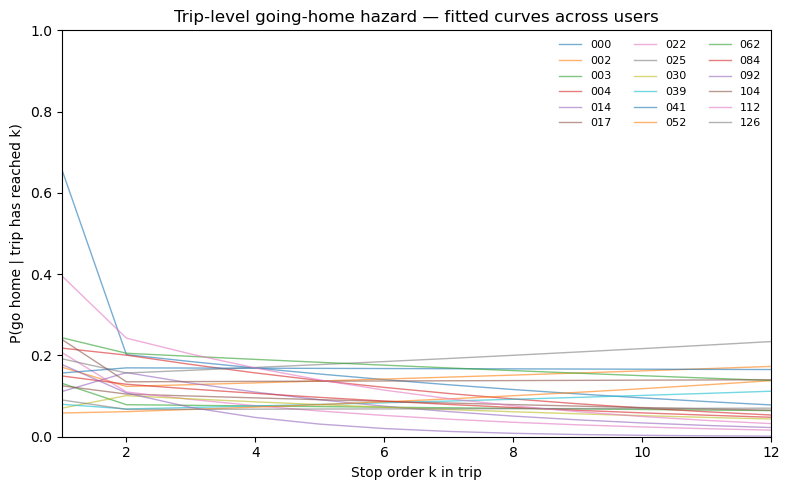

In [3]:
MAXK = 12
MIN_RISK = 20


def compute_trip_hazard_curve(vt_trips: pd.DataFrame,
                              maxk: int = MAXK,
                              min_risk: int = MIN_RISK) -> dict | None:
    """
    Given a visit table with trip_id and action_order_in_trip,
    compute:
      - empirical hazard h_k
      - fitted hazard curve via logit GLM
    Returns dict with:
      - k_axis, haz_emp, haz_hat, haz_df
    """
    vis = vt_trips[
        (vt_trips["is_home"] == 0) &
        (vt_trips["trip_id"] > 0) &
        (vt_trips["action_order_in_trip"] > 0) &
        (vt_trips["action_order_in_trip"] <= maxk)
    ].copy()

    if vis.empty:
        return None

    vis["outcome"] = np.where(
        vis["next_step"] == "home", "home",
        np.where(vis["next_step"].isin(["sw", "pv", "pn"]), "explore", "end")
    )

    last_mask = vis.groupby(
        ["person", "date", "trip_id"]
    ).cumcount(ascending=False).eq(0)

    NIGHT_HOUR = 23
    NEAR_HOME_M = 750

    last_time_dt = pd.to_datetime(
        vis["last_time"], format="%H:%M:%S", errors="coerce"
    )
    late = last_time_dt.dt.hour.ge(NIGHT_HOUR)
    near = vis["dist_home_m"].le(NEAR_HOME_M)

    vis.loc[
        last_mask & (vis["outcome"] == "end") & (late | near),
        "outcome"
    ] = "home"

    pertrip_maxk = (
        vis.groupby(["person", "date", "trip_id"])["action_order_in_trip"]
           .max()
    )

    at_risk = pd.Series(
        {k: int((pertrip_maxk >= k).sum()) for k in range(1, maxk + 1)},
        name="at_risk"
    )

    home_k = (
        vis[vis["outcome"] == "home"]
        .groupby("action_order_in_trip")
        .size()
        .reindex(range(1, maxk + 1), fill_value=0)
        .rename("home_k")
    )

    hazard = (home_k / at_risk.replace(0, np.nan)).rename("hazard")
    haz_df = pd.concat([home_k, at_risk, hazard], axis=1)

    k_axis = np.arange(1, maxk + 1)
    haz_emp = hazard.reindex(k_axis).to_numpy()

    if np.all(np.isnan(haz_emp)):
        return None

    # logit fit on k >= 2
    haz_fit = (
        haz_df
        .loc[haz_df.index >= 2]
        .loc[lambda df: df["at_risk"] >= min_risk]
        .copy()
    )

    if haz_fit.empty:
        haz_hat = haz_emp.copy()
    else:
        k_fit = haz_fit.index.values.astype(float)
        X = sm.add_constant(k_fit)
        y = np.column_stack([
            haz_fit["home_k"].values,
            (haz_fit["at_risk"] - haz_fit["home_k"]).values
        ])
        glm = sm.GLM(y, X, family=sm.families.Binomial())
        res_haz = glm.fit()

        alpha, beta = res_haz.params[0], res_haz.params[1]
        X_pred = sm.add_constant(k_axis[1:])
        haz_hat_tail = res_haz.predict(X_pred)
        h1_emp = haz_df.loc[1, "hazard"]
        haz_hat = np.concatenate([[h1_emp], haz_hat_tail])

    return {
        "k_axis": k_axis,
        "haz_emp": haz_emp,
        "haz_hat": haz_hat,
        "haz_df": haz_df,
    }


# compute hazard curves for all users
hazard_curves = {}

for uid in summary_df["uid"]:
    vt = load_visit_table_from_csv(uid, verbose=False)
    if vt is None or vt.empty:
        continue
    vt_trips = attach_trip_structure(vt)
    curve = compute_trip_hazard_curve(vt_trips, maxk=MAXK, min_risk=MIN_RISK)
    if curve is not None:
        hazard_curves[uid] = curve

print("Users with usable hazard curves:", len(hazard_curves))


# overlay fitted hazards across users
plt.figure(figsize=(8, 5))

for uid, hc in hazard_curves.items():
    plt.plot(hc["k_axis"], hc["haz_hat"], alpha=0.6, linewidth=1, label=uid)

plt.xlabel("Stop order k in trip")
plt.ylabel("P(go home | trip has reached k)")
plt.ylim(0, 1)
plt.xlim(1, MAXK)
plt.title("Trip-level going-home hazard — fitted curves across users")
plt.legend(ncol=3, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()


The figure overlays the fitted going-home hazard curves for all selected
users. The height of each curve reflects the overall tendency to return home
during a trip, whereas its shape shows how this tendency evolves with the
number of non-home stops already made. Most users exhibit a very high hazard
at the first stop, corresponding to short “one-stop errand” trips, followed
by a much lower and relatively stable hazard once the trip has continued
beyond the initial stops. In other words, after a trip has survived the
early stage, additional stops add only a modest incremental chance of going
home. A few users display slightly upward-sloping tails at larger stop
orders; these patterns are typically associated with sparse data for very
long trips, where a small number of observed returns can produce an
apparently rising hazard in the far tail rather than indicating a genuinely
different behavioural regime.


## 4. Cross-user within-trip exploration (Pv)

In this step I summarise within-trip exploration behaviour across users using
the Pv logit model. For each user, I first restrict attention to non-home
stops within home–home trips and count, for each stop order \(k \leq 10\),
how many of these stops are first-time places (Pv) versus revisits (Pn).
Using these counts, I estimate a user-specific logit model where the stop
order in the trip enters as a linear predictor (after recentring), and use
the fitted model to obtain a smooth Pv probability curve over \(k\). The
resulting fitted curves are then overlaid across users, so that differences
in both the baseline exploration rate and the slope with respect to stop
order can be inspected on a common scale.


Users with usable Pv curves: 18


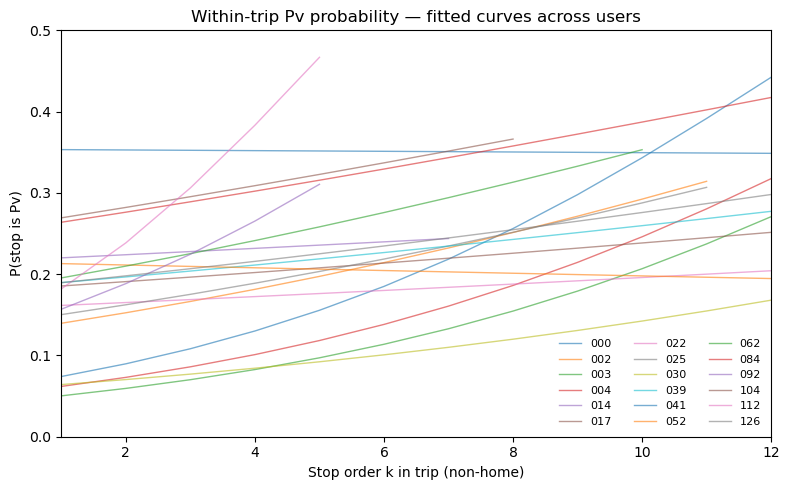

In [4]:
MAXK_PV = 12      # maximum stop order for Pv curves
MIN_N_PV = 20     # minimum n per k for fitting / error


def compute_pv_curve(vt_trips: pd.DataFrame,
                     maxk: int = MAXK_PV,
                     min_n: int = MIN_N_PV) -> dict | None:
    """
    Given a visit table with trip_id and action_order_in_trip,
    compute:
      - empirical Pv share by stop order k
      - fitted Pv probability via logit in k
    Returns dict with:
      - k_axis, pv_emp, pv_hat, pv_df
    """
    vis_places = vt_trips[
        (vt_trips["is_home"] == 0) &
        (vt_trips["trip_id"] > 0) &
        (vt_trips["action_order_in_trip"] > 0)
    ].copy()
    vis_places = vis_places[vis_places["action_order_in_trip"] <= maxk].copy()

    if vis_places.empty:
        return None

    pv_by_k = (
        vis_places
        .groupby("action_order_in_trip")[["is_pv", "is_pn"]]
        .agg(
            pv_cnt=("is_pv", "sum"),
            pn_cnt=("is_pn", "sum"),
            n=("is_pv", "size")
        )
    )

    pv_by_k = pv_by_k.reindex(range(1, maxk + 1), fill_value=0)

    denom = pv_by_k["pv_cnt"] + pv_by_k["pn_cnt"]
    pv_emp = (pv_by_k["pv_cnt"] / denom.where(denom > 0, np.nan)).to_numpy()

    k_axis = np.arange(1, maxk + 1)

    valid_k = pv_by_k.index[pv_by_k["n"] >= min_n]
    if len(valid_k) == 0:
        return {
            "k_axis": k_axis,
            "pv_emp": pv_emp,
            "pv_hat": pv_emp.copy(),
            "pv_df": pv_by_k.reset_index().rename(columns={"index": "k"})
        }

    vis_lr_sub = vis_places[
        vis_places["action_order_in_trip"].isin(valid_k)
    ].copy()

    mean_k = vis_lr_sub["action_order_in_trip"].mean()
    vis_lr_sub["k_centered"] = vis_lr_sub["action_order_in_trip"] - mean_k

    X = sm.add_constant(vis_lr_sub["k_centered"])
    y = vis_lr_sub["is_pv"]

    logit_model = sm.Logit(y, X)
    res = logit_model.fit(disp=False)

    beta0 = res.params["const"]
    beta1 = res.params["k_centered"]

    k_centered_grid = k_axis - mean_k
    lin_pred = beta0 + beta1 * k_centered_grid
    pv_hat = 1.0 / (1.0 + np.exp(-lin_pred))

    pv_df = pv_by_k.reset_index().rename(columns={"index": "k"})

    return {
        "k_axis": k_axis,
        "pv_emp": pv_emp,
        "pv_hat": pv_hat,
        "pv_df": pv_df,
    }


# compute Pv curves for all users
pv_curves = {}

for uid in summary_df["uid"]:
    vt = load_visit_table_from_csv(uid, verbose=False)
    if vt is None or vt.empty:
        continue

    vt_trips = attach_trip_structure(vt)
    curve = compute_pv_curve(vt_trips, maxk=MAXK_PV, min_n=MIN_N_PV)
    if curve is not None:
        pv_curves[uid] = curve

print("Users with usable Pv curves:", len(pv_curves))


# overlay fitted Pv curves across users
plt.figure(figsize=(8, 5))

for uid, curve in pv_curves.items():
    k_axis = curve["k_axis"]
    pv_hat = curve["pv_hat"]
    n_k = curve["pv_df"]["n"].to_numpy()

    mask_fit = n_k >= MIN_N_PV
    if not mask_fit.any():
        continue

    plt.plot(
        k_axis[mask_fit],
        pv_hat[mask_fit],
        alpha=0.6,
        linewidth=1,
        label=uid
    )

plt.ylim(0, 0.5)
plt.xlim(1, MAXK_PV)
plt.xlabel("Stop order k in trip (non-home)")
plt.ylabel("P(stop is Pv)")
plt.title("Within-trip Pv probability — fitted curves across users")
plt.legend(ncol=3, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()


The panel shows the fitted within-trip Pv probability curves for all
long-coverage users, truncated at the first ten non-home stops and only
displayed where each stop order has at least ten observations. Vertical
differences between curves reflect how exploratory a user is on average,
while the slope of each curve captures how exploration changes along the
sequence of stops within a trip. Many users exhibit a gently upward-sloping
pattern, indicating that the probability of visiting a first-time place
tends to rise as the trip proceeds, whereas a few users have nearly flat
curves, consistent with a roughly constant exploration rate across stops.


## 5. Model fit for hazard and Pv curves

To assess how well the simple logit specifications reproduce the empirical
patterns, I construct a user-level goodness-of-fit measure for both models.
For each user and each stop order within the range used in the analysis,
I compare the empirical probabilities with the corresponding fitted values
and compute a mean squared error (MSE) over the available stop orders. For
the going-home hazard, the MSE is based on all non-missing hazard points,
while for the Pv model it is restricted to stop orders with at least
`MIN_N_PV` observations. The resulting MSEs are then merged back into the
user summary table, providing a compact diagnostic of how well the fitted
curves approximate the empirical profiles for each individual.


In [5]:
# === 5.0 Compute per-user MSE for hazard and Pv ===

# 5.0.1 Hazard MSE for each user
haz_fit_rows = []
for uid, hc in hazard_curves.items():
    emp = hc["haz_emp"]      # empirical hazard h_k
    hat = hc["haz_hat"]      # fitted hazard \hat{h}_k

    mask = ~np.isnan(emp)
    if not mask.any():
        continue

    mse = np.mean((emp[mask] - hat[mask])**2)
    haz_fit_rows.append({
        "uid": uid,
        "hazard_mse": mse,
    })

haz_fit_df = (
    pd.DataFrame(haz_fit_rows)
      .sort_values("uid")
      .reset_index(drop=True)
)


# 5.0.2 Pv MSE for each user
pv_fit_rows = []
for uid, curve in pv_curves.items():
    emp = curve["pv_emp"]    # empirical Pv share by k
    hat = curve["pv_hat"]    # fitted Pv probability by k
    n_k = curve["pv_df"]["n"].to_numpy()  # sample size per k

    mask = (~np.isnan(emp)) & (n_k >= MIN_N_PV)
    if not mask.any():
        continue

    mse = np.mean((emp[mask] - hat[mask])**2)
    pv_fit_rows.append({
        "uid": uid,
        "pv_mse": mse,
    })

pv_fit_df = (
    pd.DataFrame(pv_fit_rows)
      .sort_values("uid")
      .reset_index(drop=True)
)

In [6]:
# 5.1 Hazard MSE summary
h_min   = haz_fit_df["hazard_mse"].min()
h_med   = haz_fit_df["hazard_mse"].median()
h_max   = haz_fit_df["hazard_mse"].max()

best_haz  = haz_fit_df.nsmallest(2, "hazard_mse")
worst_haz = haz_fit_df.nlargest(2, "hazard_mse")

print(f"Hazard MSE range: {h_min:.4f} – {h_max:.4f}, median {h_med:.4f}")
print("Best hazard fits:")
print(best_haz.to_string(index=False))

print("Worst hazard fits:")
print(worst_haz.to_string(index=False))


# 5.2 Pv MSE summary
p_min   = pv_fit_df["pv_mse"].min()
p_med   = pv_fit_df["pv_mse"].median()
p_max   = pv_fit_df["pv_mse"].max()

best_pv  = pv_fit_df.nsmallest(2, "pv_mse")
worst_pv = pv_fit_df.nlargest(2, "pv_mse")

print(f"\nPv MSE range: {p_min:.4f} – {p_max:.4f}, median {p_med:.4f}")
print("Best Pv fits:")
print(best_pv.to_string(index=False))

print("Worst Pv fits:")
print(worst_pv.to_string(index=False))

# 5.3 Merge fit stats into summary_df and save
summary_fit = (
    summary_df
    .merge(haz_fit_df, on="uid", how="left")
    .merge(pv_fit_df,  on="uid", how="left")
)
summary_fit.to_csv("data/user_trip_summary_with_fit.csv", index=False)


Hazard MSE range: 0.0002 – 0.0138, median 0.0013
Best hazard fits:
uid  hazard_mse
003    0.000184
030    0.000259
Worst hazard fits:
uid  hazard_mse
112    0.013826
104    0.009189

Pv MSE range: 0.0008 – 0.0091, median 0.0022
Best Pv fits:
uid   pv_mse
030 0.000807
084 0.001045
Worst Pv fits:
uid   pv_mse
112 0.009124
041 0.003860


### 5.a Hazard fit: best and worst users

Figure 5a compares the empirical trip-level going-home hazard with the fitted logit curves for the two best-fitting users (003, 030) and the two worst-fitting users (112, 104). For Users 003 and 030, the points lie almost exactly on the fitted line across stop orders 1–12, and the MSE is essentially zero, which means the simple logit trend in k captures their going-home probabilities very well. For Users 112 and 104 the overall MSE is still small (≈0.014 and ≈0.009), but the last few stops show visible deviations: with few long trips, individual “go home” events at high k create noisy empirical hazards that the smooth logit curve only approximates.


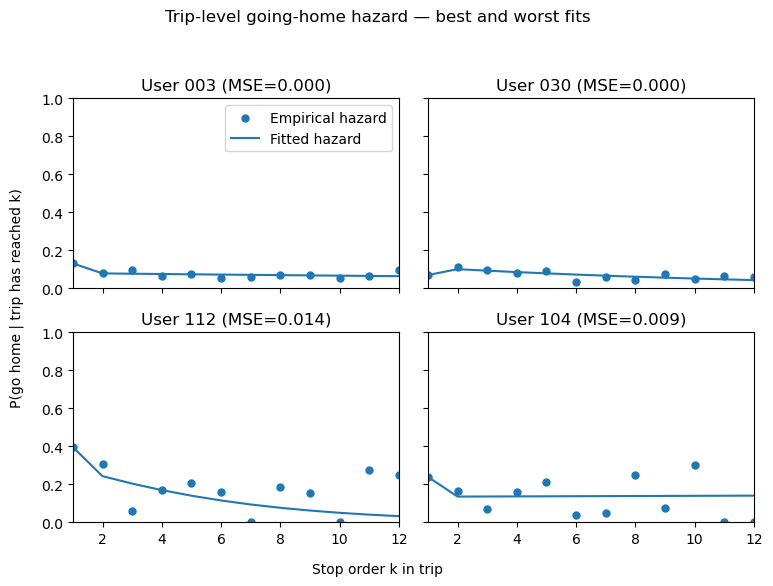

In [7]:
# 5.a Hazard fit: 2×2 panels for best and worst users

haz_best  = ["003", "030"]
haz_worst = ["112", "104"]
haz_order = haz_best + haz_worst   # top row: best, bottom row: worst

haz_mse_dict = haz_fit_df.set_index("uid")["hazard_mse"].to_dict()

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for ax, uid in zip(axes.ravel(), haz_order):
    hc  = hazard_curves[uid]
    k   = hc["k_axis"]
    emp = hc["haz_emp"]
    hat = hc["haz_hat"]

    mask_emp = ~np.isnan(emp)

    ax.scatter(k[mask_emp], emp[mask_emp], s=25, label="Empirical hazard")
    ax.plot(k, hat, label="Fitted hazard")

    ax.set_title(f"User {uid} (MSE={haz_mse_dict[uid]:.3f})")
    ax.set_xlim(1, MAXK)
    ax.set_ylim(0, 1)

axes[0, 0].legend()

fig.suptitle("Trip-level going-home hazard — best and worst fits", y=0.98)
fig.text(0.5, 0.04, "Stop order k in trip", ha="center")
fig.text(0.04, 0.5, "P(go home | trip has reached k)", va="center", rotation="vertical")

plt.tight_layout(rect=[0.06, 0.06, 1, 0.94])
plt.show()


### 5.b Pv fit: best and worst users

Figure 5b repeats the same exercise for within-trip exploration. For Users 030 and 084 (best fits), the fitted Pv probability is almost indistinguishable from the empirical Pv share for k up to 10, and the MSE stays around 0.001, indicating that a linear logit trend in stop order is an adequate summary of how exploration evolves within their trips. For Users 112 and 041 (worst fits), the fitted line still gets the general level and slope roughly right, but the empirical points at higher k fluctuate more strongly (especially for 112), reflecting sparse data for long trips rather than a systematic failure of the model.


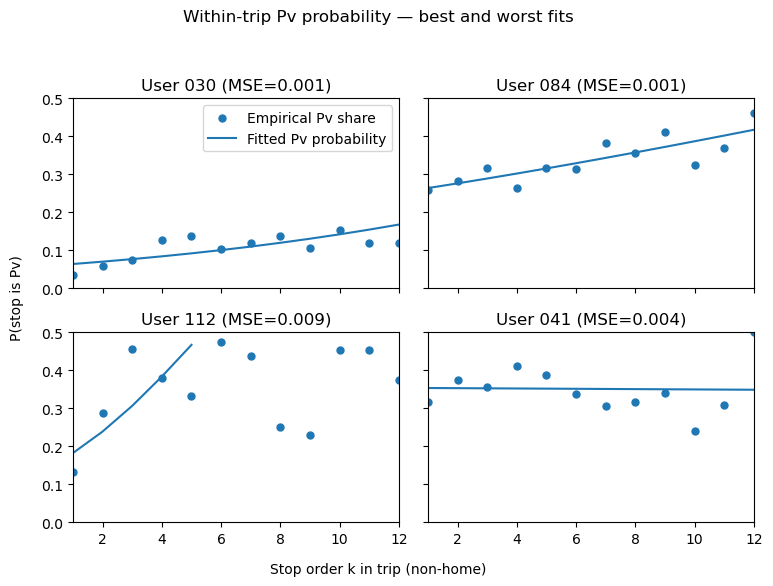

In [8]:
# 5.b Pv fit: 2×2 panels for best and worst users

pv_best  = ["030", "084"]
pv_worst = ["112", "041"]
pv_order = pv_best + pv_worst

pv_mse_dict = pv_fit_df.set_index("uid")["pv_mse"].to_dict()

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for ax, uid in zip(axes.ravel(), pv_order):
    curve = pv_curves[uid]
    k     = curve["k_axis"]
    emp   = curve["pv_emp"]
    hat   = curve["pv_hat"]
    n_k   = curve["pv_df"]["n"].to_numpy()

    mask_emp = ~np.isnan(emp)
    mask_fit = (n_k >= MIN_N_PV)

    ax.scatter(k[mask_emp], emp[mask_emp], s=25, label="Empirical Pv share")
    ax.plot(k[mask_fit], hat[mask_fit], label="Fitted Pv probability")

    ax.set_title(f"User {uid} (MSE={pv_mse_dict[uid]:.3f})")
    ax.set_xlim(1, MAXK_PV)
    ax.set_ylim(0, 0.5)

axes[0, 0].legend()

fig.suptitle("Within-trip Pv probability — best and worst fits", y=0.98)
fig.text(0.5, 0.04, "Stop order k in trip (non-home)", ha="center")
fig.text(0.04, 0.5, "P(stop is Pv)", va="center", rotation="vertical")

plt.tight_layout(rect=[0.06, 0.06, 1, 0.94])
plt.show()


## 6. User typology in multivariate trip space

For the 18 long-coverage Geolife users, I construct a nine-dimensional mobility profile capturing trip frequency, trip length, going-home behaviour, and within-trip exploration. After standardising these features, a k-means model with k = 3 identifies three distinct user types.

Cluster 0 – multi-stop revisitors
Users take relatively long trips (around seven non-home stops), have consistently low going-home hazards, and show the lowest exploration rate (about 17% Pv). Their mobility is dominated by chains of familiar places.

Cluster 1 – errand-homebodies
Trips are shorter (four to five stops), the probability of going home after the first stop is the highest, and exploration is moderate (Pv around 24%). Many outings resemble short errand trips that end quickly.

Cluster 2 – exploratory roamers
Users make fewer and shorter trips (around three stops) but show strong exploration. Once they remain out beyond the first stops, later-stop hazards stay low and Pv increases, indicating a tendency to continue visiting new places.

To understand which behavioural dimensions drive these groups, the nine features are projected onto their first three principal components. PC1 contrasts long, routinised multi-stop mobility with shorter and more exploratory patterns. PC2 reflects overall going-out frequency and activity levels. PC3 captures late-trip behaviour, separating users whose return-home probability rises at higher stop orders from those who continue to stay out.


In [11]:
feat_cols = [
    "mean_stops_per_trip",     
    "median_stops_per_trip",
    "hazard_h1",              
    "hazard_h2_const",        
    "hazard_beta_k",          
    "overall_pv_share",       
    "pv_odds_ratio_per_stop",  
    "n_trips",                
    "n_days_nonhome",        
]

X = summary_fit[feat_cols].dropna()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
summary_fit["cluster3"] = kmeans.fit_predict(X_scaled)


pca = PCA(n_components=3)
PCs = pca.fit_transform(X_scaled)
summary_fit[["PC1", "PC2", "PC3"]] = PCs

loadings = pd.DataFrame(
    pca.components_.T,
    index=feat_cols,
    columns=["PC1", "PC2", "PC3"]
)
display(loadings.round(2))

c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,PC1,PC2,PC3
mean_stops_per_trip,0.46,-0.16,0.06
median_stops_per_trip,0.43,-0.29,0.14
hazard_h1,-0.36,0.33,0.08
hazard_h2_const,-0.29,0.14,0.62
hazard_beta_k,0.25,-0.01,0.71
overall_pv_share,-0.31,-0.35,0.25
pv_odds_ratio_per_stop,-0.34,-0.07,-0.09
n_trips,0.12,0.66,0.07
n_days_nonhome,0.32,0.45,-0.05


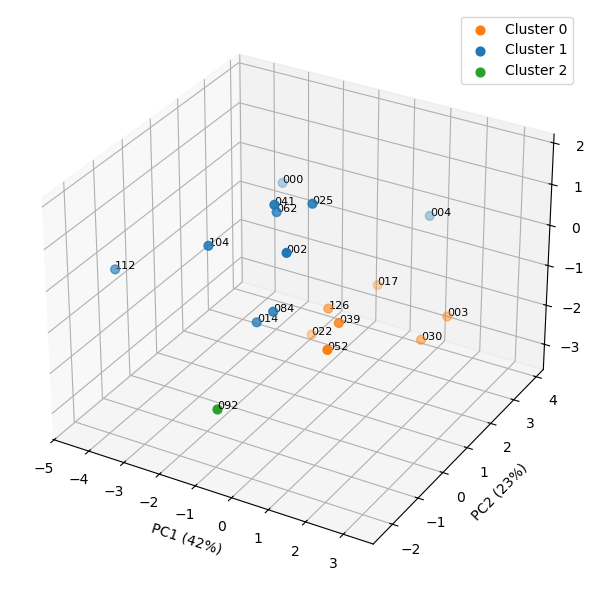

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

colors = {0: "tab:orange", 1: "tab:blue", 2: "tab:green"}

for c in sorted(summary_fit["cluster3"].unique()):
    sub = summary_fit[summary_fit["cluster3"] == c]
    ax.scatter(
        sub["PC1"], sub["PC2"], sub["PC3"],
        c=colors[c], label=f"Cluster {c}", s=40
    )
    for _, row in sub.iterrows():
        ax.text(
            row["PC1"], row["PC2"], row["PC3"],
            row["uid"],
            fontsize=8
        )

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.0%})")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.0%})")
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]:.0%})")
ax.legend()
plt.tight_layout()
plt.show()





Cluster 0 (orange) — multi-stop revisitors
This group sits mainly on the right side of PC1, indicating long trips with many non-home stops. Their PC2 values are moderate, showing a normal level of going-out frequency. PC3 tends to be low, meaning they rarely return home in the later part of a trip.
In short: long, multi-stop routines concentrated around familiar places.

Cluster 1 (blue) — errand-homebodies
These users cluster toward higher PC2, reflecting frequent going-out. Their PC1 values are slightly left or near the centre, consistent with short to medium trips. PC3 is higher than other groups, indicating a strong tendency to return home after the first one or two stops.
In short: they go out often, but most outings are short errand-like trips that end quickly.

Cluster 2 (green) — exploratory roamers
This cluster contains user 092, positioned at the low end of all three PCs: low PC1 (short trips), low PC2 (infrequent going-out), and low PC3 (very low late-trip hazard).
In short: rare outings, but whenever they go out, they behave highly exploratively rather than following routines.